# Generating prime portraits
Last week I learned about the existance of prime portraits. Unfortunatly I could not find the code, and I loved to see the same portraits in color. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
import numpy as np
from sklearn.cluster import KMeans
import random
from PIL import Image
from PIL import ImageFont

import scipy.misc
from PIL import ImageDraw 
from multiprocessing import Pool
import time

## Testing for primality
When working with extremely long primes the naive method won't work anymore. Instead we take a probabilistic approach to the prime numbers. 

In [2]:

def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.

    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        
    return True # no base tested showed n as composite

assert is_probable_prime(2)
assert is_probable_prime(3)
assert not is_probable_prime(4)
assert  is_probable_prime(5)
assert not is_probable_prime(123456789)
primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
assert len(primes_under_1000) == 168
assert primes_under_1000[-10:] == [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
assert is_probable_prime(6438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
assert not is_probable_prime(7438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)


## Generating the images
The basis of the algorithm is generating images with only 10 possible color values. Although I did not know what a common approach to this is I opted for applying a k-means algorithm on a reshaped image (so each pixel is a point in 3D speace) and using the 10 created clusters as color values. 

Important for the prime generation is that you ad a little bit of noise to the original image to create images that look the same, but actually are a different number (a new chance for a prime number!). 

In [18]:
def get_k_means(image):
    pointcloud = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(pointcloud)
    return kmeans

def create_numbered_image(image, kmeans):
    """
    Turns an RGB image into an image with the labels of clusters of the supplied kmeans classifier. 
    """
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    assert numbered_image.shape[0] < 100 and "WATCH OUT FOR THE HEIGHT OF IMAGES"
    assert numbered_image.shape[1] < 100 and "WATCH OUT FOR THE WIDTH OF IMAGES"
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    """
    Turns an image with only values between 0 and 9 into a colored image by using the cluster centers 
    of the supplied kmeans classifier. 
    """
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image


## Examples

Let's look at a few examples. As you can see each image is slightly different. 

/home/roland/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


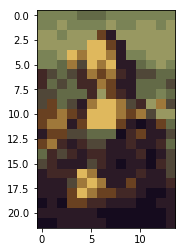

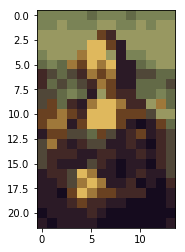

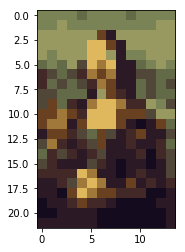

In [6]:

def load_and_resize_image(filename, resize_factor=18):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//resize_factor, oldshape[1]//resize_factor))

    return resized_image

resized_image = load_and_resize_image('input_pictures/monalisa.jpg')
kmeans = get_k_means(resized_image)
for _ in range(3):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

In [7]:
def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    resized_image= scipy.misc.imresize(image,(oldshape[0]*fontsize, oldshape[1]*fontsize), interp='nearest')
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("pirulen rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

In [8]:


def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None

In [9]:
def print_result(string, n_image):
    print(string)
    print("-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))


In [11]:
folder = 'input_pictures/'

filenames = [
    folder + 'monalisa.jpg',
    folder + 'sunflowers.jpg',
    folder + 'starrynight.jpg'
]
filename = filenames[0]

for filename in filenames:
    resized_image = load_and_resize_image(filename)
    print("Working with size " + str(resized_image.shape))

    kmeans = get_k_means(resized_image)
    
    for _ in range(10000):
        n_image = create_numbered_image(resized_image, kmeans)    
        
        result = is_good_prime_portrait(n_image)
        if result != None:
            integer, string, n_image = result
            print_result(string, n_image)
            
            normal_image = numbered_image_to_normal_image(n_image, kmeans)
            show_and_save_image(normal_image, n_image, result_filename(filename))
            
            break

/home/roland/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working with size (22, 14, 3)


KeyboardInterrupt: 

## Multi threaded attempt


Working with size (39, 26, 3)


/home/roland/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Seconds spent in (function name) is 2.3322839736938477 time per result: 0.07774279912312826
Seconds spent in (function name) is 4.300100803375244 time per result: 0.07166834672292073
Seconds spent in (function name) is 6.147165775299072 time per result: 0.06830184194776746
Seconds spent in (function name) is 8.205526351928711 time per result: 0.0683793862660726
Seconds spent in (function name) is 10.46534776687622 time per result: 0.06976898511250813
Seconds spent in (function name) is 12.795062780380249 time per result: 0.0710836821132236
Seconds spent in (function name) is 14.946219682693481 time per result: 0.07117247467949277
Seconds spent in (function name) is 17.05670475959778 time per result: 0.07106960316499074
Seconds spent in (function name) is 19.256267070770264 time per result: 0.0713195076695195
Seconds spent in (function name) is 21.333110570907593 time per result: 0.07111036856969198
Seconds spent in (function name) is 23.35389494895935 time per result: 0.070769378633210

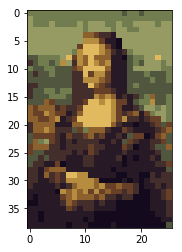

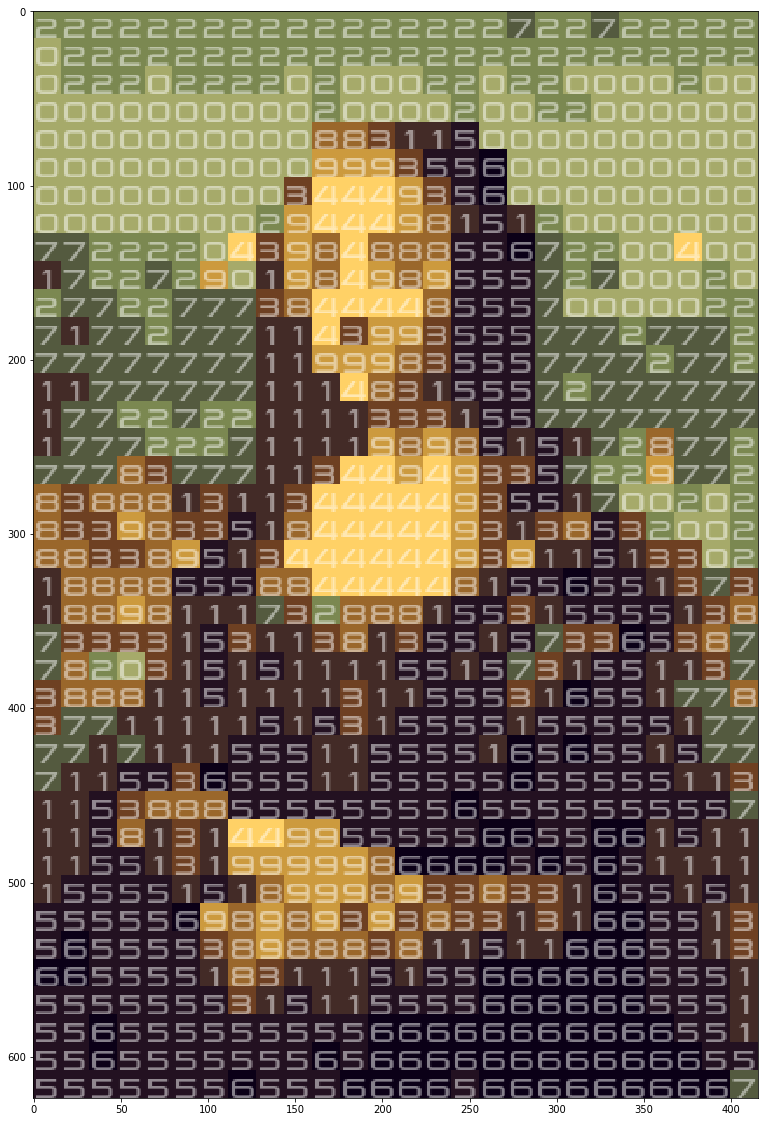

Working with size (37, 30, 3)
Seconds spent in (function name) is 2.7008137702941895 time per result: 0.09002712567647299
Seconds spent in (function name) is 4.985774040222168 time per result: 0.08309623400370279
Seconds spent in (function name) is 7.329580545425415 time per result: 0.08143978383806016
Seconds spent in (function name) is 9.960744857788086 time per result: 0.08300620714823405
Seconds spent in (function name) is 12.745717525482178 time per result: 0.08497145016988118
Seconds spent in (function name) is 15.116032123565674 time per result: 0.08397795624203153
Seconds spent in (function name) is 17.665167570114136 time per result: 0.08411984557197208
Seconds spent in (function name) is 20.136849880218506 time per result: 0.0839035411675771
Seconds spent in (function name) is 22.460124492645264 time per result: 0.08318564626905653
Seconds spent in (function name) is 24.941499710083008 time per result: 0.08313833236694336
Seconds spent in (function name) is 27.44318389892578 

Seconds spent in (function name) is 215.5271294116974 time per result: 0.07894766645117121
Seconds spent in (function name) is 217.62887167930603 time per result: 0.07885104046351668
Seconds spent in (function name) is 219.85235047340393 time per result: 0.07880012561770751
Seconds spent in (function name) is 222.0634355545044 time per result: 0.07874589913280297
Seconds spent in (function name) is 224.55390977859497 time per result: 0.07879084553634912
Seconds spent in (function name) is 226.73868656158447 time per result: 0.07872871061166127
Seconds spent in (function name) is 229.21746683120728 time per result: 0.07876888894543205
Seconds spent in (function name) is 231.52679634094238 time per result: 0.07875061100032053
Seconds spent in (function name) is 233.72094774246216 time per result: 0.07869392179880881
Seconds spent in (function name) is 236.1739366054535 time per result: 0.07872464553515117
Seconds spent in (function name) is 238.4369180202484 time per result: 0.0786920521

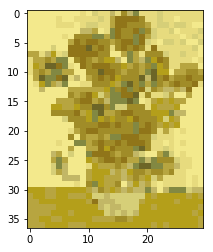

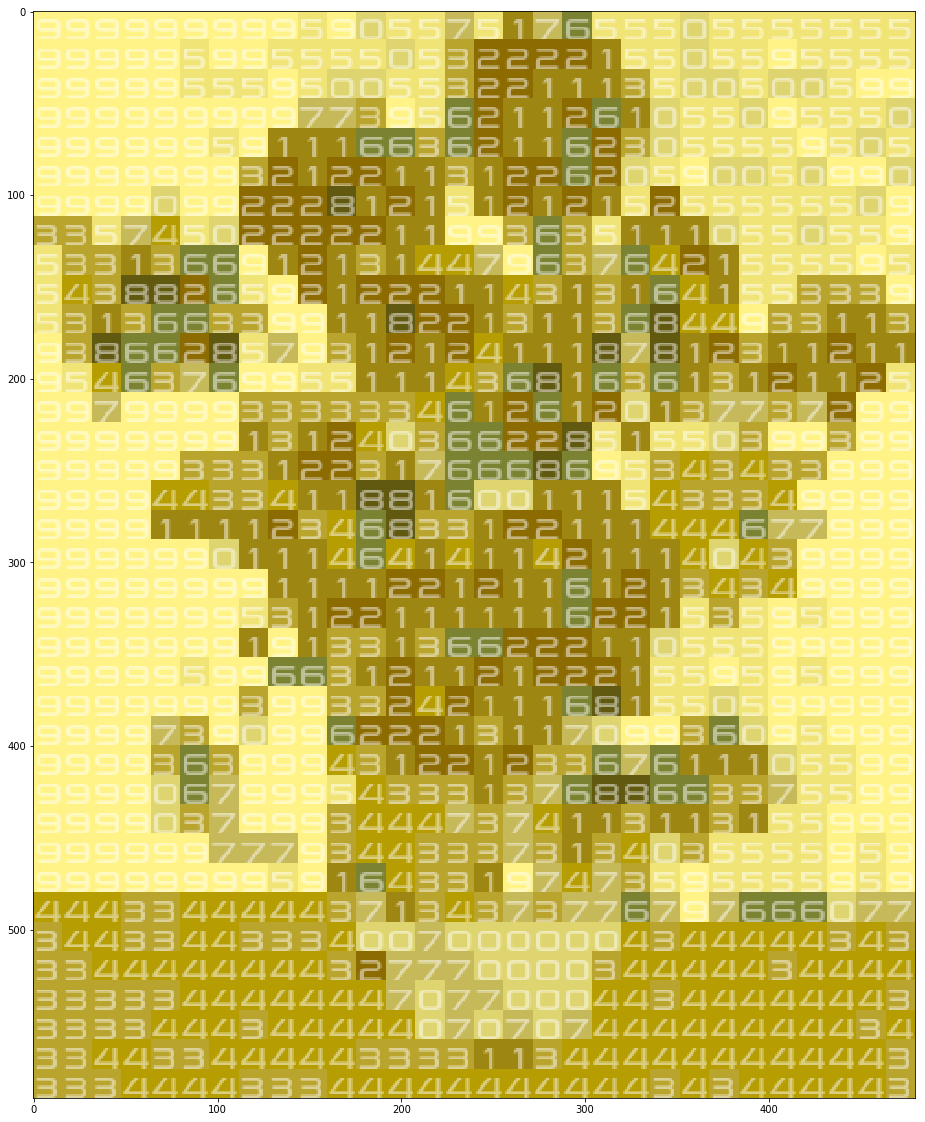

Working with size (60, 75, 3)
Seconds spent in (function name) is 85.98317217826843 time per result: 2.8661057392756146
Seconds spent in (function name) is 172.2576560974121 time per result: 2.8709609349568685
Seconds spent in (function name) is 258.1150245666504 time per result: 2.8679447174072266
Seconds spent in (function name) is 324.2447843551636 time per result: 2.702039869626363
Seconds spent in (function name) is 409.89824175834656 time per result: 2.7326549450556437
Seconds spent in (function name) is 494.86287474632263 time per result: 2.7492381930351257
Seconds spent in (function name) is 580.3444113731384 time per result: 2.7635448160625637
Seconds spent in (function name) is 647.8919370174408 time per result: 2.69954973757267
Seconds spent in (function name) is 732.7639112472534 time per result: 2.7139404120268646
Seconds spent in (function name) is 816.9840967655182 time per result: 2.7232803225517275
Seconds spent in (function name) is 901.9685113430023 time per result: 

In [ ]:

def multi_threaded_prime_generator(resized_image, kmeans, filename):


    image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(1000000))
    start = time.time() 
    with Pool(8) as pool:
        results = pool.imap_unordered(is_good_prime_portrait, image_generator)
        total_results = 0
        for result in results:
            total_results += 1
            if total_results%30==0:
                elapsed = time.time()
                elapsed = elapsed - start
                print("Seconds spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))

            if result != None:
                integer, string, n_image = result

                print("-"*100)
                print(string)
                print("-"*100)
                for line in n_image:
                    print(''.join([str(x) for x in line]))
                normal_image = numbered_image_to_normal_image(n_image, kmeans)
                plt.imshow(normal_image)
                plt.show()
                show_and_save_image(normal_image, n_image, result_filename(filename))
                break


for filename in filenames:
    
    resized_image = load_and_resize_image(filename, resize_factor=10)
    print("Working with size " + str(resized_image.shape))

    kmeans = get_k_means(resized_image)
    
    multi_threaded_prime_generator(resized_image, kmeans, filename)





In [33]:
filename = 'input_pictures/ionica.jpg'
resized_image = load_and_resize_image(filename, resize_factor=12)
print("Working with size " + str(resized_image.shape))

kmeans = get_k_means(resized_image)

multi_threaded_prime_generator(resized_image, kmeans, filename)


Working with size (28, 22, 3)


/home/roland/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Seconds spent in (function name) is 0.511124849319458 time per result: 0.017037494977315267
Seconds spent in (function name) is 0.9721667766571045 time per result: 0.01620277961095174
Seconds spent in (function name) is 1.4311742782592773 time per result: 0.015901936425103083
Seconds spent in (function name) is 1.8744606971740723 time per result: 0.015620505809783936
Seconds spent in (function name) is 2.3847601413726807 time per result: 0.01589840094248454
Seconds spent in (function name) is 2.864859104156494 time per result: 0.015915883911980525
Seconds spent in (function name) is 3.297124147415161 time per result: 0.015700591178167436
Seconds spent in (function name) is 3.7168478965759277 time per result: 0.015486866235733032
Seconds spent in (function name) is 4.172395706176758 time per result: 0.015453317430284289
Seconds spent in (function name) is 4.616064548492432 time per result: 0.015386881828308106
Seconds spent in (function name) is 5.037456035614014 time per result: 0.0152

Seconds spent in (function name) is 40.67899680137634 time per result: 0.015066295111620867
Seconds spent in (function name) is 41.12630844116211 time per result: 0.015064581846579527
Seconds spent in (function name) is 41.57159996032715 time per result: 0.015062173898669257
Seconds spent in (function name) is 41.99950313568115 time per result: 0.015053585353290735
Seconds spent in (function name) is 42.457674980163574 time per result: 0.015055913113533182
Seconds spent in (function name) is 42.90366244316101 time per result: 0.015053916646723162
Seconds spent in (function name) is 43.35863733291626 time per result: 0.01505508240726259
Seconds spent in (function name) is 43.80822682380676 time per result: 0.015054373478971397
Seconds spent in (function name) is 44.23270511627197 time per result: 0.01504513779465033
Seconds spent in (function name) is 44.69681930541992 time per result: 0.015049434109568997
Seconds spent in (function name) is 45.138044118881226 time per result: 0.0150460

Seconds spent in (function name) is 81.07692408561707 time per result: 0.015014245201040197
Seconds spent in (function name) is 81.51962184906006 time per result: 0.015012821703325978
Seconds spent in (function name) is 81.97133231163025 time per result: 0.015013064525939606
Seconds spent in (function name) is 82.43980026245117 time per result: 0.01501635706055577
Seconds spent in (function name) is 82.89117479324341 time per result: 0.015016517172689023
Seconds spent in (function name) is 83.32000970840454 time per result: 0.015012614361874692
Seconds spent in (function name) is 83.76265788078308 time per result: 0.015011229010893025
Seconds spent in (function name) is 84.20512342453003 time per result: 0.01500982592237612
Seconds spent in (function name) is 84.65325689315796 time per result: 0.01500944271155283
Seconds spent in (function name) is 85.11136174201965 time per result: 0.015010822176723043
Seconds spent in (function name) is 85.58120322227478 time per result: 0.0150142461

Seconds spent in (function name) is 120.93909931182861 time per result: 0.014986257659458317
Seconds spent in (function name) is 121.38808965682983 time per result: 0.014986183908250596
Seconds spent in (function name) is 121.86024880409241 time per result: 0.014988960492508292
Seconds spent in (function name) is 122.31292486190796 time per result: 0.014989329027194603
Seconds spent in (function name) is 122.75059914588928 time per result: 0.014987863143576224
Seconds spent in (function name) is 123.18702816963196 time per result: 0.014986256468325056
Seconds spent in (function name) is 123.62204694747925 time per result: 0.014984490539088393
Seconds spent in (function name) is 124.06750917434692 time per result: 0.014983998692553976
Seconds spent in (function name) is 124.52010250091553 time per result: 0.014984368531999461
Seconds spent in (function name) is 124.96517872810364 time per result: 0.01498383437986854
Seconds spent in (function name) is 125.41725277900696 time per result:

Seconds spent in (function name) is 160.0073835849762 time per result: 0.014898266628023854
Seconds spent in (function name) is 160.4023289680481 time per result: 0.014893438158593139
Seconds spent in (function name) is 160.85841131210327 time per result: 0.014894297343713265
Seconds spent in (function name) is 161.30940437316895 time per result: 0.014894681844244593
Seconds spent in (function name) is 161.73584866523743 time per result: 0.014892803744497
Seconds spent in (function name) is 162.16178274154663 time per result: 0.014890889140637891
Seconds spent in (function name) is 162.59765529632568 time per result: 0.014889895173656197
Seconds spent in (function name) is 163.0390374660492 time per result: 0.014889409814251069
Seconds spent in (function name) is 163.4810929298401 time per result: 0.014888988427125691
Seconds spent in (function name) is 163.92027711868286 time per result: 0.014888308548472558
Seconds spent in (function name) is 164.33758687973022 time per result: 0.014

Seconds spent in (function name) is 199.6466760635376 time per result: 0.0148878953067515
Seconds spent in (function name) is 200.07950234413147 time per result: 0.014886867733938353
Seconds spent in (function name) is 200.5178620815277 time per result: 0.014886255536861745
Seconds spent in (function name) is 200.94836902618408 time per result: 0.014885064372309933
Seconds spent in (function name) is 201.39341640472412 time per result: 0.014884953171080866
Seconds spent in (function name) is 201.82643508911133 time per result: 0.014883955390052458
Seconds spent in (function name) is 202.25262641906738 time per result: 0.01488245963348546
Seconds spent in (function name) is 202.6913661956787 time per result: 0.014881891791165837
Seconds spent in (function name) is 203.1425654888153 time per result: 0.014882239229949839
Seconds spent in (function name) is 203.58422470092773 time per result: 0.014881887770535653
Seconds spent in (function name) is 203.98289680480957 time per result: 0.014

Seconds spent in (function name) is 238.47065377235413 time per result: 0.014830264538081724
Seconds spent in (function name) is 238.89749932289124 time per result: 0.014829143347168916
Seconds spent in (function name) is 239.34930157661438 time per result: 0.014829572588389987
Seconds spent in (function name) is 239.81307697296143 time per result: 0.014830740690968548
Seconds spent in (function name) is 240.20118498802185 time per result: 0.014827233641235917
Seconds spent in (function name) is 240.6427297592163 time per result: 0.01482703202459743
Seconds spent in (function name) is 241.10297083854675 time per result: 0.014827980986380489
Seconds spent in (function name) is 241.5573320388794 time per result: 0.01482856550269364
Seconds spent in (function name) is 241.93610763549805 time per result: 0.014824516399233949
Seconds spent in (function name) is 242.39074730873108 time per result: 0.014825122159555417
Seconds spent in (function name) is 242.8416166305542 time per result: 0.0

Seconds spent in (function name) is 277.3533411026001 time per result: 0.014792178192138673
Seconds spent in (function name) is 277.8010070323944 time per result: 0.014792385890968818
Seconds spent in (function name) is 278.2562487125397 time per result: 0.01479299567849759
Seconds spent in (function name) is 278.69210267066956 time per result: 0.014792574451734052
Seconds spent in (function name) is 279.1267397403717 time per result: 0.014792090076331303
Seconds spent in (function name) is 279.55006551742554 time per result: 0.014791008757535742
Seconds spent in (function name) is 279.993674993515 time per result: 0.014791002376836504
Seconds spent in (function name) is 280.43278908729553 time per result: 0.014790758918106304
Seconds spent in (function name) is 280.86203694343567 time per result: 0.014789996679485818
Seconds spent in (function name) is 281.3034408092499 time per result: 0.014789875962631434
Seconds spent in (function name) is 281.72480940818787 time per result: 0.0147

Seconds spent in (function name) is 316.19716477394104 time per result: 0.014761772398409945
Seconds spent in (function name) is 316.6557173728943 time per result: 0.014762504306428639
Seconds spent in (function name) is 317.0842001438141 time per result: 0.014761834271127285
Seconds spent in (function name) is 317.49822521209717 time per result: 0.014760493966159794
Seconds spent in (function name) is 317.94573426246643 time per result: 0.014760711897050438
Seconds spent in (function name) is 318.3986179828644 time per result: 0.01476117839512584
Seconds spent in (function name) is 318.8232743740082 time per result: 0.014760336776574453
Seconds spent in (function name) is 319.24837946891785 time per result: 0.014759518237120565
Seconds spent in (function name) is 319.67175579071045 time per result: 0.01475862215100233
Seconds spent in (function name) is 320.1311764717102 time per result: 0.014759390339866769
Seconds spent in (function name) is 320.6039447784424 time per result: 0.0147

Seconds spent in (function name) is 355.397155046463 time per result: 0.01475289145066264
Seconds spent in (function name) is 355.83582520484924 time per result: 0.014752729071511162
Seconds spent in (function name) is 356.28271079063416 time per result: 0.014752907279115286
Seconds spent in (function name) is 356.74753642082214 time per result: 0.014753826981837144
Seconds spent in (function name) is 357.13555788993835 time per result: 0.014751571990497247
Seconds spent in (function name) is 357.57446551322937 time per result: 0.014751421844605171
Seconds spent in (function name) is 358.03902101516724 time per result: 0.014752328842816945
Seconds spent in (function name) is 358.4842338562012 time per result: 0.014752437607251078
Seconds spent in (function name) is 358.86939668655396 time per result: 0.014750077956701765
Seconds spent in (function name) is 359.31994366645813 time per result: 0.01475040819648843
Seconds spent in (function name) is 359.7775971889496 time per result: 0.01

Seconds spent in (function name) is 394.19363284111023 time per result: 0.0147307037683524
Seconds spent in (function name) is 394.6223895549774 time per result: 0.014730212376072319
Seconds spent in (function name) is 395.0767297744751 time per result: 0.014730675979659772
Seconds spent in (function name) is 395.52085041999817 time per result: 0.01473075792998131
Seconds spent in (function name) is 395.9557263851166 time per result: 0.014730495773255825
Seconds spent in (function name) is 396.35684967041016 time per result: 0.014728979920862511
Seconds spent in (function name) is 396.8186070919037 time per result: 0.014729718154859083
Seconds spent in (function name) is 397.2734658718109 time per result: 0.014730198957056392
Seconds spent in (function name) is 397.71290349960327 time per result: 0.014730107537022344
Seconds spent in (function name) is 398.0992360115051 time per result: 0.014728051646744547
Seconds spent in (function name) is 398.5558965206146 time per result: 0.014728

Seconds spent in (function name) is 433.49748396873474 time per result: 0.014714782212109123
Seconds spent in (function name) is 433.93269896507263 time per result: 0.014714571005936677
Seconds spent in (function name) is 434.38355565071106 time per result: 0.014714890096568803
Seconds spent in (function name) is 434.8015191555023 time per result: 0.014714095402893479
Seconds spent in (function name) is 435.2385947704315 time per result: 0.014713948437134264
Seconds spent in (function name) is 435.68204069137573 time per result: 0.014714016909536498
Seconds spent in (function name) is 436.11941838264465 time per result: 0.014713880512234975
Seconds spent in (function name) is 436.5390422344208 time per result: 0.01471314601396767
Seconds spent in (function name) is 436.98637104034424 time per result: 0.014713345826274217
Seconds spent in (function name) is 437.4302752017975 time per result: 0.014713430043787336
Seconds spent in (function name) is 437.84770679473877 time per result: 0.0

Seconds spent in (function name) is 472.2866232395172 time per result: 0.014699241308419458
Seconds spent in (function name) is 472.70638608932495 time per result: 0.014698581657006373
Seconds spent in (function name) is 473.12065505981445 time per result: 0.014697752564765904
Seconds spent in (function name) is 473.57329654693604 time per result: 0.014698115969799381
Seconds spent in (function name) is 474.01772832870483 time per result: 0.014698224134223406
Seconds spent in (function name) is 474.4617896080017 time per result: 0.014698320619826571
Seconds spent in (function name) is 474.9043378829956 time per result: 0.014698370098514256
Seconds spent in (function name) is 475.3071801662445 time per result: 0.014697191718189378
Seconds spent in (function name) is 475.7597897052765 time per result: 0.014697552972050556
Seconds spent in (function name) is 476.1897597312927 time per result: 0.014697214806521381
Seconds spent in (function name) is 476.64346575737 time per result: 0.01469

Seconds spent in (function name) is 511.1557333469391 time per result: 0.014688383142153422
Seconds spent in (function name) is 511.61174154281616 time per result: 0.014688824046592483
Seconds spent in (function name) is 512.0417556762695 time per result: 0.014688518521981341
Seconds spent in (function name) is 512.4399127960205 time per result: 0.014687300452737763
Seconds spent in (function name) is 512.901061296463 time per result: 0.014687888353277863
Seconds spent in (function name) is 513.3548858165741 time per result: 0.014688265688600117
Seconds spent in (function name) is 513.7748382091522 time per result: 0.014687674048289086
Seconds spent in (function name) is 514.1865165233612 time per result: 0.014686847087213973
Seconds spent in (function name) is 514.6479816436768 time per result: 0.014687442398506757
Seconds spent in (function name) is 515.0911741256714 time per result: 0.014687515657988919
Seconds spent in (function name) is 515.5068762302399 time per result: 0.0146868

Seconds spent in (function name) is 550.422785282135 time per result: 0.014677940940856934
Seconds spent in (function name) is 550.8816182613373 time per result: 0.014678433739977013
Seconds spent in (function name) is 551.3305444717407 time per result: 0.014678661993390327
Seconds spent in (function name) is 551.7547619342804 time per result: 0.014678232560103229
Seconds spent in (function name) is 552.1852855682373 time per result: 0.014677971439878717
Seconds spent in (function name) is 552.6381244659424 time per result: 0.014678303438670449
Seconds spent in (function name) is 553.0650207996368 time per result: 0.014677946411879958
Seconds spent in (function name) is 553.5129725933075 time per result: 0.014678148305311787
Seconds spent in (function name) is 553.9451327323914 time per result: 0.014677931444949426
Seconds spent in (function name) is 554.3679864406586 time per result: 0.014677468531656303
Seconds spent in (function name) is 554.7884457111359 time per result: 0.01467694

Seconds spent in (function name) is 589.7448728084564 time per result: 0.014670270467872051
Seconds spent in (function name) is 590.1630263328552 time per result: 0.014669724741060285
Seconds spent in (function name) is 590.5932376384735 time per result: 0.014669479325347082
Seconds spent in (function name) is 591.0527300834656 time per result: 0.014669961034585892
Seconds spent in (function name) is 591.4826233386993 time per result: 0.01466970792010663
Seconds spent in (function name) is 591.9017736911774 time per result: 0.014669188939062636
Seconds spent in (function name) is 592.3593919277191 time per result: 0.01466962337611984
Seconds spent in (function name) is 592.7918343544006 time per result: 0.014669434158733003
Seconds spent in (function name) is 593.2263369560242 time per result: 0.014669296166073792
Seconds spent in (function name) is 593.6810479164124 time per result: 0.014669657719703789
Seconds spent in (function name) is 594.1150288581848 time per result: 0.014669506

Seconds spent in (function name) is 629.1458032131195 time per result: 0.014665403338301153
Seconds spent in (function name) is 629.5969679355621 time per result: 0.0146656642892048
Seconds spent in (function name) is 630.0153524875641 time per result: 0.014665161836302702
Seconds spent in (function name) is 630.475691318512 time per result: 0.014665635992521795
Seconds spent in (function name) is 630.9151065349579 time per result: 0.014665623117967408
Seconds spent in (function name) is 631.3357627391815 time per result: 0.014665174511943822
Seconds spent in (function name) is 631.7609720230103 time per result: 0.014664832219661333
Seconds spent in (function name) is 632.2106349468231 time per result: 0.014665057642004712
Seconds spent in (function name) is 632.6611604690552 time per result: 0.014665302746153342
Seconds spent in (function name) is 633.0734353065491 time per result: 0.014664661461814896
Seconds spent in (function name) is 633.5167062282562 time per result: 0.0146647385

Seconds spent in (function name) is 668.4410743713379 time per result: 0.014658795490599515
Seconds spent in (function name) is 668.8836176395416 time per result: 0.014658856402356818
Seconds spent in (function name) is 669.3265559673309 time per result: 0.014658925886275317
Seconds spent in (function name) is 669.7612390518188 time per result: 0.01465881459951453
Seconds spent in (function name) is 670.2135753631592 time per result: 0.014659089574872247
Seconds spent in (function name) is 670.6689703464508 time per result: 0.014659431045824062
Seconds spent in (function name) is 671.055844783783 time per result: 0.01465827533385284
Seconds spent in (function name) is 671.5005314350128 time per result: 0.014658383135451055
Seconds spent in (function name) is 671.9610188007355 time per result: 0.01465883548867224
Seconds spent in (function name) is 672.4094951152802 time per result: 0.01465902540037672
Seconds spent in (function name) is 672.7951591014862 time per result: 0.014657846603

Seconds spent in (function name) is 707.7275776863098 time per result: 0.014652744879633743
Seconds spent in (function name) is 708.1245203018188 time per result: 0.014651862617459524
Seconds spent in (function name) is 708.5569531917572 time per result: 0.014651715326545849
Seconds spent in (function name) is 709.0124554634094 time per result: 0.014652044956879716
Seconds spent in (function name) is 709.4598889350891 time per result: 0.014652207536866772
Seconds spent in (function name) is 709.8953504562378 time per result: 0.014652122816434217
Seconds spent in (function name) is 710.3107755184174 time per result: 0.014651624907558114
Seconds spent in (function name) is 710.7484393119812 time per result: 0.014651586050545892
Seconds spent in (function name) is 711.2039895057678 time per result: 0.014651915729414253
Seconds spent in (function name) is 711.6275095939636 time per result: 0.014651585538273906
Seconds spent in (function name) is 712.0579426288605 time per result: 0.0146513

Seconds spent in (function name) is 747.035727262497 time per result: 0.014647759358088175
Seconds spent in (function name) is 747.4981667995453 time per result: 0.014648210205752406
Seconds spent in (function name) is 747.9540271759033 time per result: 0.014648531672070178
Seconds spent in (function name) is 748.4148163795471 time per result: 0.014648949234283561
Seconds spent in (function name) is 748.8788013458252 time per result: 0.01464942882131896
Seconds spent in (function name) is 749.3833918571472 time per result: 0.014650701698086945
Seconds spent in (function name) is 749.8569025993347 time per result: 0.014651365818666173
Seconds spent in (function name) is 750.340231180191 time per result: 0.014652220878347805
Seconds spent in (function name) is 750.9256579875946 time per result: 0.014655067486096695
Seconds spent in (function name) is 751.404194355011 time per result: 0.014655825909011332
Seconds spent in (function name) is 751.8700742721558 time per result: 0.01465633673

Seconds spent in (function name) is 787.0870344638824 time per result: 0.01465711423582649
Seconds spent in (function name) is 787.5301530361176 time per result: 0.014657177610945794
Seconds spent in (function name) is 787.9520273208618 time per result: 0.014656845746295792
Seconds spent in (function name) is 788.4131424427032 time per result: 0.014657243771011401
Seconds spent in (function name) is 788.8187425136566 time per result: 0.014656609857184255
Seconds spent in (function name) is 789.2775616645813 time per result: 0.014656964933418408
Seconds spent in (function name) is 789.7268877029419 time per result: 0.01465714342433077
Seconds spent in (function name) is 790.162736415863 time per result: 0.014657071719826805
Seconds spent in (function name) is 790.5843348503113 time per result: 0.014656735907495574
Seconds spent in (function name) is 791.0318403244019 time per result: 0.014656880495171425
Seconds spent in (function name) is 791.4728050231934 time per result: 0.0146569037

Seconds spent in (function name) is 826.4554409980774 time per result: 0.014653465265923357
Seconds spent in (function name) is 826.8965570926666 time per result: 0.014653492062602634
Seconds spent in (function name) is 827.3184659481049 time per result: 0.014653178638825804
Seconds spent in (function name) is 827.7541246414185 time per result: 0.014653108950989882
Seconds spent in (function name) is 828.1896872520447 time per result: 0.01465303763715578
Seconds spent in (function name) is 828.6312682628632 time per result: 0.014653072825161153
Seconds spent in (function name) is 829.0854420661926 time per result: 0.014653330541997042
Seconds spent in (function name) is 829.5054433345795 time per result: 0.014652984337300468
Seconds spent in (function name) is 829.9320502281189 time per result: 0.01465275512408402
Seconds spent in (function name) is 830.3671412467957 time per result: 0.014652675864598477
Seconds spent in (function name) is 830.8246467113495 time per result: 0.014652992

Seconds spent in (function name) is 865.8338484764099 time per result: 0.01465031892515076
Seconds spent in (function name) is 866.2561986446381 time per result: 0.014650028727289668
Seconds spent in (function name) is 866.6878883838654 time per result: 0.014649896693439239
Seconds spent in (function name) is 867.1458714008331 time per result: 0.01465020901167145
Seconds spent in (function name) is 867.570187330246 time per result: 0.014649952504732286
Seconds spent in (function name) is 868.0117678642273 time per result: 0.014649987643278097
Seconds spent in (function name) is 868.443197965622 time per result: 0.014649851517638696
Seconds spent in (function name) is 868.8791265487671 time per result: 0.014649791376644194
Seconds spent in (function name) is 869.340292930603 time per result: 0.014650156604829845
Seconds spent in (function name) is 869.7663021087646 time per result: 0.014649929292719634
Seconds spent in (function name) is 870.1888329982758 time per result: 0.014649643653

Seconds spent in (function name) is 905.1445097923279 time per result: 0.014646351291137992
Seconds spent in (function name) is 905.6106054782867 time per result: 0.014646783203595127
Seconds spent in (function name) is 906.0098261833191 time per result: 0.014646133627276415
Seconds spent in (function name) is 906.4587047100067 time per result: 0.014646287036839662
Seconds spent in (function name) is 906.8953456878662 time per result: 0.014646242662917737
Seconds spent in (function name) is 907.3431718349457 time per result: 0.014646378883534232
Seconds spent in (function name) is 907.7882664203644 time per result: 0.01464647090061898
Seconds spent in (function name) is 908.2193212509155 time per result: 0.014646336417528069
Seconds spent in (function name) is 908.6413867473602 time per result: 0.014646057168719539
Seconds spent in (function name) is 909.1006677150726 time per result: 0.014646377762446795
Seconds spent in (function name) is 909.5430853366852 time per result: 0.01464642

Seconds spent in (function name) is 944.4765229225159 time per result: 0.01464304686701575
Seconds spent in (function name) is 944.9131135940552 time per result: 0.01464300501462971
Seconds spent in (function name) is 945.3749272823334 time per result: 0.014643353892229451
Seconds spent in (function name) is 945.7964036464691 time per result: 0.014643077932287802
Seconds spent in (function name) is 946.2331283092499 time per result: 0.014643038197295727
Seconds spent in (function name) is 946.6687564849854 time per result: 0.014642981538824212
Seconds spent in (function name) is 947.1320164203644 time per result: 0.014643352140079845
Seconds spent in (function name) is 947.5606029033661 time per result: 0.014643186569361245
Seconds spent in (function name) is 947.9801173210144 time per result: 0.014642881021331702
Seconds spent in (function name) is 948.4143497943878 time per result: 0.014642802992039336
Seconds spent in (function name) is 948.862642288208 time per result: 0.0146429420

Seconds spent in (function name) is 983.8848536014557 time per result: 0.014641143654783566
Seconds spent in (function name) is 984.3088066577911 time per result: 0.014640916356653148
Seconds spent in (function name) is 984.7385065555573 time per result: 0.014640774703472454
Seconds spent in (function name) is 985.1877398490906 time per result: 0.014640923463354
Seconds spent in (function name) is 985.6280167102814 time per result: 0.014640939047983978
Seconds spent in (function name) is 986.0322983264923 time per result: 0.014640420168173605
Seconds spent in (function name) is 986.4930031299591 time per result: 0.014640739138170957
Seconds spent in (function name) is 986.9294168949127 time per result: 0.014640697476560046
Seconds spent in (function name) is 987.3752987384796 time per result: 0.014640796244639378
Seconds spent in (function name) is 987.8087892532349 time per result: 0.014640711268018896
Seconds spent in (function name) is 988.225038766861 time per result: 0.01464037094

Seconds spent in (function name) is 1022.8340425491333 time per result: 0.01463910179689614
Seconds spent in (function name) is 1023.2005360126495 time per result: 0.0146380620316545
Seconds spent in (function name) is 1023.6625089645386 time per result: 0.014638388516581419
Seconds spent in (function name) is 1024.1208255290985 time per result: 0.014638662457534283
Seconds spent in (function name) is 1024.5742318630219 time per result: 0.014638866007472807
Seconds spent in (function name) is 1024.9461994171143 time per result: 0.014637906304157587
Seconds spent in (function name) is 1025.4032888412476 time per result: 0.014638162581602393
Seconds spent in (function name) is 1025.8515858650208 time per result: 0.01463829317729767
Seconds spent in (function name) is 1026.3015041351318 time per result: 0.014638446785553157
Seconds spent in (function name) is 1026.7354049682617 time per result: 0.014638371898606525
Seconds spent in (function name) is 1027.1361825466156 time per result: 0.

Seconds spent in (function name) is 1061.6995673179626 time per result: 0.014636056897132101
Seconds spent in (function name) is 1062.1453461647034 time per result: 0.01463614918237155
Seconds spent in (function name) is 1062.5550544261932 time per result: 0.014635744551324976
Seconds spent in (function name) is 1063.0198502540588 time per result: 0.01463609872303537
Seconds spent in (function name) is 1063.4588310718536 time per result: 0.01463609731725645
Seconds spent in (function name) is 1063.891274690628 time per result: 0.014636005980060917
Seconds spent in (function name) is 1064.3473720550537 time per result: 0.014636239989755963
Seconds spent in (function name) is 1064.7662732601166 time per result: 0.014635962519039402
Seconds spent in (function name) is 1065.2153351306915 time per result: 0.014636099685774822
Seconds spent in (function name) is 1065.6475195884705 time per result: 0.014636004938723671
Seconds spent in (function name) is 1066.0783360004425 time per result: 0.

Seconds spent in (function name) is 1101.1485240459442 time per result: 0.014640985561041674
Seconds spent in (function name) is 1101.598263502121 time per result: 0.01464112524590804
Seconds spent in (function name) is 1102.0559267997742 time per result: 0.014641370091666987
Seconds spent in (function name) is 1102.4578247070312 time per result: 0.014640874166096033
Seconds spent in (function name) is 1102.9025530815125 time per result: 0.01464094720671064
Seconds spent in (function name) is 1103.3456268310547 time per result: 0.014640998232896161
Seconds spent in (function name) is 1103.7947971820831 time per result: 0.014641130085980676
Seconds spent in (function name) is 1104.2256095409393 time per result: 0.014641018424037913
Seconds spent in (function name) is 1104.6553966999054 time per result: 0.014640893263086884
Seconds spent in (function name) is 1105.0964419841766 time per result: 0.014640917355381249
Seconds spent in (function name) is 1105.529825925827 time per result: 0.

Seconds spent in (function name) is 1140.1313920021057 time per result: 0.014639591576811835
Seconds spent in (function name) is 1140.59446310997 time per result: 0.014639898127454372
Seconds spent in (function name) is 1141.038328409195 time per result: 0.014639958024239093
Seconds spent in (function name) is 1141.4369566440582 time per result: 0.014639437689419754
Seconds spent in (function name) is 1141.8871376514435 time per result: 0.014639578687839019
Seconds spent in (function name) is 1142.3428654670715 time per result: 0.014639790663425242
Seconds spent in (function name) is 1142.772613286972 time per result: 0.01463966965522639
Seconds spent in (function name) is 1143.1884393692017 time per result: 0.014639370461892709
Seconds spent in (function name) is 1143.6301379203796 time per result: 0.014639402687152837
Seconds spent in (function name) is 1144.081830739975 time per result: 0.014639562773384197
Seconds spent in (function name) is 1144.527001619339 time per result: 0.014

Seconds spent in (function name) is 1179.048973083496 time per result: 0.014637479492035954
Seconds spent in (function name) is 1179.4549226760864 time per result: 0.014637067791959375
Seconds spent in (function name) is 1179.8986020088196 time per result: 0.014637124451170073
Seconds spent in (function name) is 1180.3349342346191 time per result: 0.014637089958266606
Seconds spent in (function name) is 1180.7938649654388 time per result: 0.014637335626198572
Seconds spent in (function name) is 1181.2031662464142 time per result: 0.014636966124490882
Seconds spent in (function name) is 1181.6441428661346 time per result: 0.01463698925883977
Seconds spent in (function name) is 1182.095606803894 time per result: 0.014637142233827316
Seconds spent in (function name) is 1182.5347011089325 time per result: 0.014637141986742572
Seconds spent in (function name) is 1182.961941242218 time per result: 0.014636995066100198
Seconds spent in (function name) is 1183.3988344669342 time per result: 0.

Seconds spent in (function name) is 1217.9192349910736 time per result: 0.014634934330582475
Seconds spent in (function name) is 1218.3694384098053 time per result: 0.01463506832924691
Seconds spent in (function name) is 1218.8117361068726 time per result: 0.014635107301955722
Seconds spent in (function name) is 1219.2500185966492 time per result: 0.014635098050613962
Seconds spent in (function name) is 1219.663723707199 time per result: 0.014634793900974311
Seconds spent in (function name) is 1220.133766412735 time per result: 0.014635165724034244
Seconds spent in (function name) is 1220.5836963653564 time per result: 0.014635296119488687
Seconds spent in (function name) is 1220.993171930313 time per result: 0.014634941530987811
Seconds spent in (function name) is 1221.4281795024872 time per result: 0.014634893116492777
Seconds spent in (function name) is 1221.8799223899841 time per result: 0.014635045183734388
Seconds spent in (function name) is 1222.3281924724579 time per result: 0.

Seconds spent in (function name) is 1257.4394340515137 time per result: 0.01464011449588443
Seconds spent in (function name) is 1257.8640592098236 time per result: 0.014639944823205582
Seconds spent in (function name) is 1258.285016298294 time per result: 0.014639732592184922
Seconds spent in (function name) is 1258.7231168746948 time per result: 0.014639719898519364
Seconds spent in (function name) is 1259.1687552928925 time per result: 0.014639794852841443
Seconds spent in (function name) is 1259.6041159629822 time per result: 0.014639750301754791
Seconds spent in (function name) is 1260.0224199295044 time per result: 0.014639507609265766
Seconds spent in (function name) is 1260.4802224636078 time per result: 0.01463972383813714
Seconds spent in (function name) is 1260.92489027977 time per result: 0.01463978741762185
Seconds spent in (function name) is 1261.383299589157 time per result: 0.01464001044091408
Seconds spent in (function name) is 1261.775556564331 time per result: 0.01463

Seconds spent in (function name) is 1296.3083992004395 time per result: 0.0146376287172588
Seconds spent in (function name) is 1296.7676486968994 time per result: 0.014637855838095716
Seconds spent in (function name) is 1297.1609725952148 time per result: 0.014637338891843994
Seconds spent in (function name) is 1297.6243731975555 time per result: 0.014637612782826345
Seconds spent in (function name) is 1298.065737247467 time per result: 0.014637637993318303
Seconds spent in (function name) is 1298.4962389469147 time per result: 0.014637540738889806
Seconds spent in (function name) is 1298.91073679924 time per result: 0.01463726320485959
Seconds spent in (function name) is 1299.3656766414642 time per result: 0.014637441440142663
Seconds spent in (function name) is 1299.8006026744843 time per result: 0.01463739417426221
Seconds spent in (function name) is 1300.2514760494232 time per result: 0.014637526466840294
Seconds spent in (function name) is 1300.6720740795135 time per result: 0.014

Seconds spent in (function name) is 1335.2347249984741 time per result: 0.014635917187312004
Seconds spent in (function name) is 1335.6673011779785 time per result: 0.014635845947600028
Seconds spent in (function name) is 1336.0915892124176 time per result: 0.01463568396552106
Seconds spent in (function name) is 1336.5543749332428 time per result: 0.01463594365892732
Seconds spent in (function name) is 1337.0125603675842 time per result: 0.014636152822852591
Seconds spent in (function name) is 1337.425832748413 time per result: 0.014635870351810167
Seconds spent in (function name) is 1337.8549690246582 time per result: 0.014635761612784796
Seconds spent in (function name) is 1338.2944025993347 time per result: 0.014635765557735507
Seconds spent in (function name) is 1338.736409664154 time per result: 0.014635797634898372
Seconds spent in (function name) is 1339.1811790466309 time per result: 0.014635859880291048
Seconds spent in (function name) is 1339.5975544452667 time per result: 0.

Seconds spent in (function name) is 1374.1790914535522 time per result: 0.014634495116651249
Seconds spent in (function name) is 1374.614859342575 time per result: 0.01463446033580938
Seconds spent in (function name) is 1375.0497691631317 time per result: 0.014634416444903488
Seconds spent in (function name) is 1375.5103240013123 time per result: 0.014634645430378894
Seconds spent in (function name) is 1375.9238686561584 time per result: 0.014634374267774499
Seconds spent in (function name) is 1376.3469471931458 time per result: 0.014634204648518296
Seconds spent in (function name) is 1376.8013105392456 time per result: 0.014634367671548104
Seconds spent in (function name) is 1377.2556428909302 time per result: 0.014634530261299863
Seconds spent in (function name) is 1377.6683320999146 time per result: 0.014634250394092996
Seconds spent in (function name) is 1378.1078822612762 time per result: 0.014634255944157123
Seconds spent in (function name) is 1378.5542168617249 time per result: 

Seconds spent in (function name) is 1413.3256492614746 time per result: 0.01463524541018406
Seconds spent in (function name) is 1413.7623603343964 time per result: 0.014635221121474083
Seconds spent in (function name) is 1414.211873292923 time per result: 0.01463532933139732
Seconds spent in (function name) is 1414.6275379657745 time per result: 0.014635087295321482
Seconds spent in (function name) is 1415.0574884414673 time per result: 0.014634993157942571
Seconds spent in (function name) is 1415.5169558525085 time per result: 0.014635204258193844
Seconds spent in (function name) is 1415.9726724624634 time per result: 0.014635376459560345
Seconds spent in (function name) is 1416.366532087326 time per result: 0.014634909403671481
Seconds spent in (function name) is 1416.8023948669434 time per result: 0.014634876509316634
Seconds spent in (function name) is 1417.2623624801636 time per result: 0.014635092549361458
Seconds spent in (function name) is 1417.715471982956 time per result: 0.0

Seconds spent in (function name) is 1452.2006175518036 time per result: 0.014633218637160455
Seconds spent in (function name) is 1452.6523609161377 time per result: 0.014633347042572154
Seconds spent in (function name) is 1453.102345943451 time per result: 0.014633457663076041
Seconds spent in (function name) is 1453.5230476856232 time per result: 0.014633273408694485
Seconds spent in (function name) is 1453.9454855918884 time per result: 0.014633106739048796
Seconds spent in (function name) is 1454.4148824214935 time per result: 0.01463341264132703
Seconds spent in (function name) is 1454.836438179016 time per result: 0.014633237157302515
Seconds spent in (function name) is 1455.2456760406494 time per result: 0.014632937918960778
Seconds spent in (function name) is 1455.7000558376312 time per result: 0.014633092640104858
Seconds spent in (function name) is 1456.156141281128 time per result: 0.0146332644084125
Seconds spent in (function name) is 1456.5853040218353 time per result: 0.01

Seconds spent in (function name) is 1491.1591687202454 time per result: 0.014632118229028018
Seconds spent in (function name) is 1491.591563463211 time per result: 0.014632053791085061
Seconds spent in (function name) is 1492.0455868244171 time per result: 0.014632201498719398
Seconds spent in (function name) is 1492.474695444107 time per result: 0.014632104857295167
Seconds spent in (function name) is 1492.8866708278656 time per result: 0.014631840349190097
Seconds spent in (function name) is 1493.3269696235657 time per result: 0.01463185351385034
Seconds spent in (function name) is 1493.7757456302643 time per result: 0.014631949707417614
Seconds spent in (function name) is 1494.2249031066895 time per result: 0.014632049579971499
Seconds spent in (function name) is 1494.627590894699 time per result: 0.014631694477676937
Seconds spent in (function name) is 1495.0683505535126 time per result: 0.014631712180010888
Seconds spent in (function name) is 1495.5208055973053 time per result: 0.

Seconds spent in (function name) is 1530.0560686588287 time per result: 0.01463048449664208
Seconds spent in (function name) is 1530.4815788269043 time per result: 0.014630356360069824
Seconds spent in (function name) is 1530.9253885746002 time per result: 0.014630403178274085
Seconds spent in (function name) is 1531.3341822624207 time per result: 0.014630115431952046
Seconds spent in (function name) is 1531.7852954864502 time per result: 0.014630232048581186
Seconds spent in (function name) is 1532.2354381084442 time per result: 0.01463033933074042
Seconds spent in (function name) is 1532.6664187908173 time per result: 0.014630263638705777
Seconds spent in (function name) is 1533.084321975708 time per result: 0.014630063192820956
Seconds spent in (function name) is 1533.545169353485 time per result: 0.014630272556320217
Seconds spent in (function name) is 1533.9662907123566 time per result: 0.014630102915711556
Seconds spent in (function name) is 1534.4081454277039 time per result: 0.

Seconds spent in (function name) is 1569.4047284126282 time per result: 0.014633144320863666
Seconds spent in (function name) is 1569.825522661209 time per result: 0.014632974670592927
Seconds spent in (function name) is 1570.2486097812653 time per result: 0.014632826481979921
Seconds spent in (function name) is 1570.7021043300629 time per result: 0.014632961657630547
Seconds spent in (function name) is 1571.1512563228607 time per result: 0.014633056312963218
Seconds spent in (function name) is 1571.5637872219086 time per result: 0.01463280993688928
Seconds spent in (function name) is 1572.0089190006256 time per result: 0.014632867160016994
Seconds spent in (function name) is 1572.4660241603851 time per result: 0.014633035772942352
Seconds spent in (function name) is 1572.8970022201538 time per result: 0.014632961226348069
Seconds spent in (function name) is 1573.3239090442657 time per result: 0.014632848856438483
Seconds spent in (function name) is 1573.7570872306824 time per result: 

Seconds spent in (function name) is 1608.33660364151 time per result: 0.014631883220901656
Seconds spent in (function name) is 1608.778870344162 time per result: 0.014631913327368459
Seconds spent in (function name) is 1609.2357149124146 time per result: 0.014632075967561508
Seconds spent in (function name) is 1609.6756193637848 time per result: 0.014632084531986046
Seconds spent in (function name) is 1610.0870399475098 time per result: 0.014631834241616773
Seconds spent in (function name) is 1610.539470911026 time per result: 0.014631956672217917
Seconds spent in (function name) is 1610.9670760631561 time per result: 0.01463185355189061
Seconds spent in (function name) is 1611.4266543388367 time per result: 0.014632040809396502
Seconds spent in (function name) is 1611.8569378852844 time per result: 0.014631962035995682
Seconds spent in (function name) is 1612.2895085811615 time per result: 0.014631904061903634
Seconds spent in (function name) is 1612.7339520454407 time per result: 0.0

Seconds spent in (function name) is 1647.3065147399902 time per result: 0.014631019759658853
Seconds spent in (function name) is 1647.7295484542847 time per result: 0.014630878604637583
Seconds spent in (function name) is 1648.1846451759338 time per result: 0.014631022149808557
Seconds spent in (function name) is 1648.630614042282 time per result: 0.014631084611663845
Seconds spent in (function name) is 1649.0362131595612 time per result: 0.014630788866645029
Seconds spent in (function name) is 1649.4661588668823 time per result: 0.014630709232454162
Seconds spent in (function name) is 1649.9287729263306 time per result: 0.014630919330729188
Seconds spent in (function name) is 1650.3752582073212 time per result: 0.014630986331625188
Seconds spent in (function name) is 1650.7697339057922 time per result: 0.014630592341627158
Seconds spent in (function name) is 1651.2256090641022 time per result: 0.014630742593160571
Seconds spent in (function name) is 1651.672149181366 time per result: 

Seconds spent in (function name) is 1686.2230632305145 time per result: 0.014629733326657249
Seconds spent in (function name) is 1686.630604982376 time per result: 0.014629461401529847
Seconds spent in (function name) is 1687.070549249649 time per result: 0.014629470597031296
Seconds spent in (function name) is 1687.5109503269196 time per result: 0.01462948374795769
Seconds spent in (function name) is 1687.958967924118 time per result: 0.014629562904525203
Seconds spent in (function name) is 1688.3768854141235 time per result: 0.014629381209722932
Seconds spent in (function name) is 1688.813749551773 time per result: 0.014629363734855969
Seconds spent in (function name) is 1689.2658121585846 time per result: 0.014629477891734516
Seconds spent in (function name) is 1689.6980123519897 time per result: 0.014629420020363548
Seconds spent in (function name) is 1690.127870798111 time per result: 0.014629341909444395
Seconds spent in (function name) is 1690.5732159614563 time per result: 0.01

Seconds spent in (function name) is 1725.1105268001556 time per result: 0.014628258516070174
Seconds spent in (function name) is 1725.5289273262024 time per result: 0.014628085175705343
Seconds spent in (function name) is 1725.9585580825806 time per result: 0.0146280071029967
Seconds spent in (function name) is 1726.4043464660645 time per result: 0.014628065975818205
Seconds spent in (function name) is 1726.8479018211365 time per result: 0.014628105902762699
Seconds spent in (function name) is 1727.3089528083801 time per result: 0.01462829397703574
Seconds spent in (function name) is 1727.685776233673 time per result: 0.01462776882764942
Seconds spent in (function name) is 1728.1465048789978 time per result: 0.014627954163526306
Seconds spent in (function name) is 1728.6060621738434 time per result: 0.014628129492881808
Seconds spent in (function name) is 1729.0299899578094 time per result: 0.014628003299135444
Seconds spent in (function name) is 1729.4590981006622 time per result: 0.0

Seconds spent in (function name) is 1764.0331580638885 time per result: 0.014627140614128429
Seconds spent in (function name) is 1764.4756767749786 time per result: 0.014627171323675525
Seconds spent in (function name) is 1764.880688905716 time per result: 0.014626891172764098
Seconds spent in (function name) is 1765.340163230896 time per result: 0.014627062418020515
Seconds spent in (function name) is 1765.771450996399 time per result: 0.014627000091090117
Seconds spent in (function name) is 1766.2169749736786 time per result: 0.014627055693363799
Seconds spent in (function name) is 1766.6601176261902 time per result: 0.01462709155179823
Seconds spent in (function name) is 1767.0809812545776 time per result: 0.014626942978682044
Seconds spent in (function name) is 1767.5092420578003 time per result: 0.0146268556939573
Seconds spent in (function name) is 1767.9601719379425 time per result: 0.014626956001803115
Seconds spent in (function name) is 1768.4152030944824 time per result: 0.01

Seconds spent in (function name) is 1802.9034793376923 time per result: 0.014625646786222862
Seconds spent in (function name) is 1803.3441927433014 time per result: 0.014625662552662623
Seconds spent in (function name) is 1803.754861831665 time per result: 0.014625434702275723
Seconds spent in (function name) is 1804.2111406326294 time per result: 0.014625576691250239
Seconds spent in (function name) is 1804.662991285324 time per result: 0.014625682723764681
Seconds spent in (function name) is 1805.0880932807922 time per result: 0.014625571976023271
Seconds spent in (function name) is 1805.4953317642212 time per result: 0.014625316579702076
Seconds spent in (function name) is 1805.9487617015839 time per result: 0.0146254353879299
Seconds spent in (function name) is 1806.407286643982 time per result: 0.014625595390203076
Seconds spent in (function name) is 1806.8195369243622 time per result: 0.014625380742466911
Seconds spent in (function name) is 1807.2527239322662 time per result: 0.0

Seconds spent in (function name) is 1841.7633571624756 time per result: 0.014624133374324881
Seconds spent in (function name) is 1842.1778845787048 time per result: 0.01462394129220215
Seconds spent in (function name) is 1842.6141650676727 time per result: 0.01462392194498153
Seconds spent in (function name) is 1843.0580327510834 time per result: 0.0146239628084669
Seconds spent in (function name) is 1843.510056257248 time per result: 0.0146240683504462
Seconds spent in (function name) is 1843.9416298866272 time per result: 0.01462401165744014
Seconds spent in (function name) is 1844.3663578033447 time per result: 0.014623900712046818
Seconds spent in (function name) is 1844.8154611587524 time per result: 0.014623983045253686
Seconds spent in (function name) is 1845.2684626579285 time per result: 0.014624096232825555
Seconds spent in (function name) is 1845.673050403595 time per result: 0.014623825769777315
Seconds spent in (function name) is 1846.1011638641357 time per result: 0.01462

Seconds spent in (function name) is 1880.623372077942 time per result: 0.014622683866557358
Seconds spent in (function name) is 1881.0439031124115 time per result: 0.014622542779169866
Seconds spent in (function name) is 1881.4842286109924 time per result: 0.014622555596572568
Seconds spent in (function name) is 1881.9188375473022 time per result: 0.014622523990266529
Seconds spent in (function name) is 1882.3583815097809 time per result: 0.014622530734947415
Seconds spent in (function name) is 1882.801775932312 time per result: 0.014622567380648587
Seconds spent in (function name) is 1883.2371954917908 time per result: 0.014622542087831281
Seconds spent in (function name) is 1883.6581168174744 time per result: 0.014622404260343691
Seconds spent in (function name) is 1884.1255662441254 time per result: 0.014622627599876798
Seconds spent in (function name) is 1884.5469512939453 time per result: 0.01462249341475749
Seconds spent in (function name) is 1884.9914224147797 time per result: 0

Seconds spent in (function name) is 1919.567856311798 time per result: 0.014621936748261717
Seconds spent in (function name) is 1919.9951648712158 time per result: 0.014621850315065233
Seconds spent in (function name) is 1920.4281651973724 time per result: 0.014621807257479613
Seconds spent in (function name) is 1920.8803656101227 time per result: 0.014621910372308158
Seconds spent in (function name) is 1921.3306767940521 time per result: 0.014621999062359605
Seconds spent in (function name) is 1921.773360490799 time per result: 0.014622029677324804
Seconds spent in (function name) is 1922.1892561912537 time per result: 0.01462185650533435
Seconds spent in (function name) is 1922.6317348480225 time per result: 0.01462188557949671
Seconds spent in (function name) is 1923.0661482810974 time per result: 0.014621853317222456
Seconds spent in (function name) is 1923.5183386802673 time per result: 0.014621956204334985
Seconds spent in (function name) is 1923.9297814369202 time per result: 0.

Seconds spent in (function name) is 1958.5006783008575 time per result: 0.014621132350137048
Seconds spent in (function name) is 1958.9450135231018 time per result: 0.01462117490314302
Seconds spent in (function name) is 1959.3552868366241 time per result: 0.014620963262716396
Seconds spent in (function name) is 1959.8039155006409 time per result: 0.0146210378655673
Seconds spent in (function name) is 1960.2585530281067 time per result: 0.014621157253883096
Seconds spent in (function name) is 1960.6836595535278 time per result: 0.014621056372509529
Seconds spent in (function name) is 1961.1196827888489 time per result: 0.014621036925287772
Seconds spent in (function name) is 1961.5539886951447 time per result: 0.014621004686159397
Seconds spent in (function name) is 1961.997662782669 time per result: 0.01462104227425791
Seconds spent in (function name) is 1962.4315621852875 time per result: 0.014621007019708594
Seconds spent in (function name) is 1962.8794074058533 time per result: 0.0

Seconds spent in (function name) is 1997.4770426750183 time per result: 0.014620678104779815
Seconds spent in (function name) is 1997.9010157585144 time per result: 0.0146205709166375
Seconds spent in (function name) is 1998.346131324768 time per result: 0.014620618461550834
Seconds spent in (function name) is 1998.7786712646484 time per result: 0.01462057399798587
Seconds spent in (function name) is 1999.1981401443481 time per result: 0.01462043396331979
Seconds spent in (function name) is 1999.6468448638916 time per result: 0.014620507749242463
Seconds spent in (function name) is 2000.082533121109 time per result: 0.014620486353224481
Seconds spent in (function name) is 2000.5404343605042 time per result: 0.014620627306588498
Seconds spent in (function name) is 2000.9553833007812 time per result: 0.014620454357012869
Seconds spent in (function name) is 2001.3849487304688 time per result: 0.014620388258678273
Seconds spent in (function name) is 2001.841932296753 time per result: 0.014

Seconds spent in (function name) is 2036.3388950824738 time per result: 0.014619419162053799
Seconds spent in (function name) is 2036.7708730697632 time per result: 0.01461937175617114
Seconds spent in (function name) is 2037.2246322631836 time per result: 0.014619480676449111
Seconds spent in (function name) is 2037.6749503612518 time per result: 0.014619564861251627
Seconds spent in (function name) is 2038.0896620750427 time per result: 0.01461939360214506
Seconds spent in (function name) is 2038.5137736797333 time per result: 0.01461928982845477
Seconds spent in (function name) is 2038.956839799881 time per result: 0.014619322003297347
Seconds spent in (function name) is 2039.4113466739655 time per result: 0.014619436176874305
Seconds spent in (function name) is 2039.8346390724182 time per result: 0.014619326589782973
Seconds spent in (function name) is 2040.2640914916992 time per result: 0.01461926118867655
Seconds spent in (function name) is 2040.7132499217987 time per result: 0.0

Seconds spent in (function name) is 2075.2560963630676 time per result: 0.014618597466631921
Seconds spent in (function name) is 2075.695856809616 time per result: 0.014618605935696994
Seconds spent in (function name) is 2076.123372554779 time per result: 0.014618528183036045
Seconds spent in (function name) is 2076.5609714984894 time per result: 0.014618521446663072
Seconds spent in (function name) is 2076.9885346889496 time per result: 0.014618444078610286
Seconds spent in (function name) is 2077.4470269680023 time per result: 0.014618584385110142
Seconds spent in (function name) is 2077.8626248836517 time per result: 0.014618422856927337
Seconds spent in (function name) is 2078.321879386902 time per result: 0.01461856847004925
Seconds spent in (function name) is 2078.731236934662 time per result: 0.014618363128935738
Seconds spent in (function name) is 2079.179121494293 time per result: 0.014618428752684336
Seconds spent in (function name) is 2079.635399580002 time per result: 0.014

Seconds spent in (function name) is 2114.119271993637 time per result: 0.014617432565813712
Seconds spent in (function name) is 2114.5515537261963 time per result: 0.014617389421582997
Seconds spent in (function name) is 2114.9771988391876 time per result: 0.014617300427390888
Seconds spent in (function name) is 2115.415987253189 time per result: 0.014617302288924746
Seconds spent in (function name) is 2115.857759475708 time per result: 0.014617324763217327
Seconds spent in (function name) is 2116.3208622932434 time per result: 0.014617494559284731
Seconds spent in (function name) is 2116.7337744235992 time per result: 0.014617317688167939
Seconds spent in (function name) is 2117.153764486313 time per result: 0.01461718975756913
Seconds spent in (function name) is 2117.592833042145 time per result: 0.014617193573839614
Seconds spent in (function name) is 2118.04723072052 time per result: 0.014617303179575708
Seconds spent in (function name) is 2118.4744515419006 time per result: 0.0146

Seconds spent in (function name) is 2152.904716014862 time per result: 0.014615782186115832
Seconds spent in (function name) is 2153.3259420394897 time per result: 0.014615665119388378
Seconds spent in (function name) is 2153.7805190086365 time per result: 0.014615774423239932
Seconds spent in (function name) is 2154.216285467148 time per result: 0.014615756058532789
Seconds spent in (function name) is 2154.631222486496 time per result: 0.014615596408129806
Seconds spent in (function name) is 2155.0858783721924 time per result: 0.01461570619445366
Seconds spent in (function name) is 2155.521987915039 time per result: 0.01461569018114347
Seconds spent in (function name) is 2155.962554693222 time per result: 0.014615704390842804
Seconds spent in (function name) is 2156.367630004883 time per result: 0.014615478039886694
Seconds spent in (function name) is 2156.8176839351654 time per result: 0.0146155565761006
Seconds spent in (function name) is 2157.270575284958 time per result: 0.0146156

Seconds spent in (function name) is 2191.7947676181793 time per result: 0.014614888095073544
Seconds spent in (function name) is 2192.248144865036 time per result: 0.014614987632433574
Seconds spent in (function name) is 2192.70353102684 time per result: 0.01461510052007492
Seconds spent in (function name) is 2193.125109434128 time per result: 0.014614988067667119
Seconds spent in (function name) is 2193.53959941864 time per result: 0.014614828432398162
Seconds spent in (function name) is 2193.9916689395905 time per result: 0.014614919190911208
Seconds spent in (function name) is 2194.4362013339996 time per result: 0.014614959715844153
Seconds spent in (function name) is 2194.8794317245483 time per result: 0.014614991554964365
Seconds spent in (function name) is 2195.318747520447 time per result: 0.014614997320554202
Seconds spent in (function name) is 2195.7482137680054 time per result: 0.014614937525079908
Seconds spent in (function name) is 2196.185312271118 time per result: 0.01461

Seconds spent in (function name) is 2230.639755964279 time per result: 0.014613730057417972
Seconds spent in (function name) is 2231.093365430832 time per result: 0.014613829602612378
Seconds spent in (function name) is 2231.5229246616364 time per result: 0.014613771608786092
Seconds spent in (function name) is 2231.942610502243 time per result: 0.014613648991699358
Seconds spent in (function name) is 2232.383047580719 time per result: 0.014613662264864618
Seconds spent in (function name) is 2232.821278333664 time per result: 0.014613661092569305
Seconds spent in (function name) is 2233.2667615413666 time per result: 0.014613707378231687
Seconds spent in (function name) is 2233.685563325882 time per result: 0.014613579086201386
Seconds spent in (function name) is 2234.1201164722443 time per result: 0.014613553875407144
Seconds spent in (function name) is 2234.554916381836 time per result: 0.014613530288286155
Seconds spent in (function name) is 2235.0124032497406 time per result: 0.014

Seconds spent in (function name) is 2269.415502309799 time per result: 0.014612166005471633
Seconds spent in (function name) is 2269.8295691013336 time per result: 0.014612009586077853
Seconds spent in (function name) is 2270.293225288391 time per result: 0.014612172396784393
Seconds spent in (function name) is 2270.720332622528 time per result: 0.014612099952525921
Seconds spent in (function name) is 2271.166799068451 time per result: 0.014612152088196944
Seconds spent in (function name) is 2271.581472158432 time per result: 0.014611999692258022
Seconds spent in (function name) is 2272.0475492477417 time per result: 0.01461217794872816
Seconds spent in (function name) is 2272.4728293418884 time per result: 0.014612093810068727
Seconds spent in (function name) is 2272.892672777176 time per result: 0.014611974752665869
Seconds spent in (function name) is 2273.3447296619415 time per result: 0.014612062795101823
Seconds spent in (function name) is 2273.791007757187 time per result: 0.0146

Seconds spent in (function name) is 2308.4163961410522 time per result: 0.014612079985701052
Seconds spent in (function name) is 2308.8520455360413 time per result: 0.014612062815872674
Seconds spent in (function name) is 2309.259020090103 time per result: 0.01461186421216213
Seconds spent in (function name) is 2309.6921746730804 time per result: 0.014611831306845577
Seconds spent in (function name) is 2310.1523401737213 time per result: 0.014611969261060856
Seconds spent in (function name) is 2310.595645904541 time per result: 0.014612000543252646
Seconds spent in (function name) is 2311.039824485779 time per result: 0.014612037332358238
Seconds spent in (function name) is 2311.439522266388 time per result: 0.014611792921590417
Seconds spent in (function name) is 2311.882740020752 time per result: 0.014611823663384857
Seconds spent in (function name) is 2312.344334602356 time per result: 0.014611970518814256
Seconds spent in (function name) is 2312.77894449234 time per result: 0.01461

Seconds spent in (function name) is 2347.310048341751 time per result: 0.014611329276948342
Seconds spent in (function name) is 2347.764373779297 time per result: 0.01461142876387414
Seconds spent in (function name) is 2348.198616027832 time per result: 0.014611403248259797
Seconds spent in (function name) is 2348.6068387031555 time per result: 0.014611215868502897
Seconds spent in (function name) is 2349.0651133060455 time per result: 0.014611339884966384
Seconds spent in (function name) is 2349.4817249774933 time per result: 0.01461120475732272
Seconds spent in (function name) is 2349.9337663650513 time per result: 0.014611289973046393
Seconds spent in (function name) is 2350.382478237152 time per result: 0.014611354458766332
Seconds spent in (function name) is 2350.799271583557 time per result: 0.01461122053318141
Seconds spent in (function name) is 2351.241409301758 time per result: 0.014611244154249053
Seconds spent in (function name) is 2351.6759395599365 time per result: 0.01461

Seconds spent in (function name) is 2386.1972303390503 time per result: 0.01461056349705517
Seconds spent in (function name) is 2386.6431736946106 time per result: 0.014610610184846102
Seconds spent in (function name) is 2387.0553081035614 time per result: 0.014610449921064765
Seconds spent in (function name) is 2387.5013325214386 time per result: 0.014610497108631286
Seconds spent in (function name) is 2387.933233499527 time per result: 0.014610457865268765
Seconds spent in (function name) is 2388.383356809616 time per result: 0.014610530108335573
Seconds spent in (function name) is 2388.810380935669 time per result: 0.014610461045478097
Seconds spent in (function name) is 2389.258143424988 time per result: 0.01461051882483329
Seconds spent in (function name) is 2389.666177749634 time per result: 0.014610333686412532
Seconds spent in (function name) is 2390.1111249923706 time per result: 0.014610374258771139
Seconds spent in (function name) is 2390.5468623638153 time per result: 0.014

Seconds spent in (function name) is 2425.0251758098602 time per result: 0.014609465484727153
Seconds spent in (function name) is 2425.4794385433197 time per result: 0.014609561730775326
Seconds spent in (function name) is 2425.911996126175 time per result: 0.014609527227498795
Seconds spent in (function name) is 2426.3767178058624 time per result: 0.014609686402973643
Seconds spent in (function name) is 2426.8018453121185 time per result: 0.014609607159786398
Seconds spent in (function name) is 2427.23286819458 time per result: 0.014609563429605033
Seconds spent in (function name) is 2427.6822106838226 time per result: 0.014609629961387871
Seconds spent in (function name) is 2428.135240316391 time per result: 0.014609718654129909
Seconds spent in (function name) is 2428.544159412384 time per result: 0.014609541956400072
Seconds spent in (function name) is 2428.994754076004 time per result: 0.01460961598746544
Seconds spent in (function name) is 2429.452273130417 time per result: 0.0146

Seconds spent in (function name) is 2463.942272901535 time per result: 0.014608930824745257
Seconds spent in (function name) is 2464.368824005127 time per result: 0.014608861367034957
Seconds spent in (function name) is 2464.786543369293 time per result: 0.014608739588485617
Seconds spent in (function name) is 2465.230737686157 time per result: 0.014608774741843895
Seconds spent in (function name) is 2465.6727006435394 time per result: 0.014608796662184734
Seconds spent in (function name) is 2466.115303993225 time per result: 0.014608822368302974
Seconds spent in (function name) is 2466.521392583847 time per result: 0.014608631796871873
Seconds spent in (function name) is 2466.974668979645 time per result: 0.014608720725881713
Seconds spent in (function name) is 2467.4035658836365 time per result: 0.014608665280542549
Seconds spent in (function name) is 2467.841628551483 time per result: 0.01460866411265899
Seconds spent in (function name) is 2468.2890565395355 time per result: 0.01460

Seconds spent in (function name) is 2505.406504869461 time per result: 0.014623279664212112
Seconds spent in (function name) is 2505.8327674865723 time per result: 0.014623207093175609
Seconds spent in (function name) is 2506.272268295288 time per result: 0.014623211787708082
Seconds spent in (function name) is 2506.7685086727142 time per result: 0.014623547477964731
Seconds spent in (function name) is 2507.212907075882 time per result: 0.014623580677024683
Seconds spent in (function name) is 2507.709292411804 time per result: 0.014623917030626337
Seconds spent in (function name) is 2508.1159961223602 time per result: 0.014623730372120345
Seconds spent in (function name) is 2508.5549664497375 time per result: 0.014623731878569066
Seconds spent in (function name) is 2509.05003285408 time per result: 0.014624060341866762
Seconds spent in (function name) is 2509.5123839378357 time per result: 0.014624198041595779
Seconds spent in (function name) is 2509.9714653491974 time per result: 0.01

Seconds spent in (function name) is 2546.2173640727997 time per result: 0.01463343312685517
Seconds spent in (function name) is 2546.69766831398 time per result: 0.014633670449428145
Seconds spent in (function name) is 2547.2343068122864 time per result: 0.014634231338689454
Seconds spent in (function name) is 2547.7179844379425 time per result: 0.014634487819162172
Seconds spent in (function name) is 2548.19455242157 time per result: 0.014634703379402538
Seconds spent in (function name) is 2548.6804237365723 time per result: 0.014634972286744602
Seconds spent in (function name) is 2549.1872506141663 time per result: 0.014635361411265164
Seconds spent in (function name) is 2549.6872708797455 time per result: 0.014635711330461773
Seconds spent in (function name) is 2550.190329551697 time per result: 0.01463607856721589
Seconds spent in (function name) is 2550.6731510162354 time per result: 0.014636329551938
Seconds spent in (function name) is 2551.2032787799835 time per result: 0.014636

Seconds spent in (function name) is 2587.647566318512 time per result: 0.014646785341702112
Seconds spent in (function name) is 2588.10742855072 time per result: 0.01464690112365999
Seconds spent in (function name) is 2588.5114998817444 time per result: 0.014646701181925787
Seconds spent in (function name) is 2588.976696252823 time per result: 0.014646847116162157
Seconds spent in (function name) is 2589.4410231113434 time per result: 0.014646988082534892
Seconds spent in (function name) is 2589.890580177307 time per result: 0.014647045470972215
Seconds spent in (function name) is 2590.335879802704 time per result: 0.014647078766201322
Seconds spent in (function name) is 2590.791043281555 time per result: 0.01464716781592919
Seconds spent in (function name) is 2591.236527442932 time per result: 0.014647202122225606
Seconds spent in (function name) is 2591.6841921806335 time per result: 0.014647248740706643
Seconds spent in (function name) is 2592.0968976020813 time per result: 0.014647

Seconds spent in (function name) is 2627.094847202301 time per result: 0.014648683211789344
Seconds spent in (function name) is 2627.549434185028 time per result: 0.014648767542983934
Seconds spent in (function name) is 2628.011209964752 time per result: 0.014648891917306311
Seconds spent in (function name) is 2628.388471841812 time per result: 0.014648545236815538
Seconds spent in (function name) is 2628.857326030731 time per result: 0.014648709049541575
Seconds spent in (function name) is 2629.2969591617584 time per result: 0.014648710007029686
Seconds spent in (function name) is 2629.738822698593 time per result: 0.014648723388472555
Seconds spent in (function name) is 2630.1712696552277 time per result: 0.014648684319995699
Seconds spent in (function name) is 2630.5953097343445 time per result: 0.014648598450464108
Seconds spent in (function name) is 2631.059579372406 time per result: 0.014648736592463706
Seconds spent in (function name) is 2631.483967065811 time per result: 0.0146

Seconds spent in (function name) is 2666.1323306560516 time per result: 0.014648273889654699
Seconds spent in (function name) is 2666.5635137557983 time per result: 0.01464822848690287
Seconds spent in (function name) is 2666.9659864902496 time per result: 0.014648025410502826
Seconds spent in (function name) is 2667.4146053791046 time per result: 0.014648075812076358
Seconds spent in (function name) is 2667.8741607666016 time per result: 0.014648186244806466
Seconds spent in (function name) is 2668.301378250122 time per result: 0.014648119116436771
Seconds spent in (function name) is 2668.715861558914 time per result: 0.014647982115148549
Seconds spent in (function name) is 2669.1722061634064 time per result: 0.014648074888395382
Seconds spent in (function name) is 2669.6107239723206 time per result: 0.01464806981603468
Seconds spent in (function name) is 2670.038733959198 time per result: 0.014648007098744777
Seconds spent in (function name) is 2670.4934344291687 time per result: 0.0

Seconds spent in (function name) is 2704.988335132599 time per result: 0.01464689373582737
Seconds spent in (function name) is 2705.4121787548065 time per result: 0.014646809478397523
Seconds spent in (function name) is 2705.839946269989 time per result: 0.014646746488416093
Seconds spent in (function name) is 2706.280731201172 time per result: 0.014646753970889062
Seconds spent in (function name) is 2706.732257604599 time per result: 0.014646819575782462
Seconds spent in (function name) is 2707.1509971618652 time per result: 0.014646707770177273
Seconds spent in (function name) is 2707.595696210861 time per result: 0.01464673642870746
Seconds spent in (function name) is 2708.010334253311 time per result: 0.014646602489335882
Seconds spent in (function name) is 2708.4756886959076 time per result: 0.014646742854725869
Seconds spent in (function name) is 2708.8981578350067 time per result: 0.01464665129945935
Seconds spent in (function name) is 2709.3163590431213 time per result: 0.01464

Seconds spent in (function name) is 2743.801244497299 time per result: 0.014645322895635438
Seconds spent in (function name) is 2744.227705001831 time per result: 0.0146452540559389
Seconds spent in (function name) is 2744.689026594162 time per result: 0.014645371253370482
Seconds spent in (function name) is 2745.14271569252 time per result: 0.014645447693622067
Seconds spent in (function name) is 2745.5672495365143 time per result: 0.014645368589835783
Seconds spent in (function name) is 2745.9931602478027 time per result: 0.014645296854654948
Seconds spent in (function name) is 2746.4252560138702 time per result: 0.014645258124107451
Seconds spent in (function name) is 2746.873112678528 time per result: 0.014645303437185583
Seconds spent in (function name) is 2747.326878786087 time per result: 0.014645380237678378
Seconds spent in (function name) is 2747.7495789527893 time per result: 0.014645291434563423
Seconds spent in (function name) is 2748.16295671463 time per result: 0.0146451

Seconds spent in (function name) is 2782.693432331085 time per result: 0.0146442134108572
Seconds spent in (function name) is 2783.144793510437 time per result: 0.014644276735124636
Seconds spent in (function name) is 2783.572702407837 time per result: 0.014644216658290387
Seconds spent in (function name) is 2784.031478881836 time per result: 0.014644318967344359
Seconds spent in (function name) is 2784.4558062553406 time per result: 0.014644240066558014
Seconds spent in (function name) is 2784.8893506526947 time per result: 0.014644209657951804
Seconds spent in (function name) is 2785.317666053772 time per result: 0.014644151766844226
Seconds spent in (function name) is 2785.7707693576813 time per result: 0.01464422419890491
Seconds spent in (function name) is 2786.222086906433 time per result: 0.014644287222256034
Seconds spent in (function name) is 2786.62539935112 time per result: 0.014644097952341794
Seconds spent in (function name) is 2787.0764565467834 time per result: 0.0146441

Seconds spent in (function name) is 2821.6562435626984 time per result: 0.01464350118616793
Seconds spent in (function name) is 2822.056352376938 time per result: 0.014643297801872861
Seconds spent in (function name) is 2822.4961698055267 time per result: 0.014643300491857468
Seconds spent in (function name) is 2822.9481112957 time per result: 0.01464336607166563
Seconds spent in (function name) is 2823.3863394260406 time per result: 0.014643360507370161
Seconds spent in (function name) is 2823.8211443424225 time per result: 0.014643337193229737
Seconds spent in (function name) is 2824.2453298568726 time per result: 0.014643258826447205
Seconds spent in (function name) is 2824.6912574768066 time per result: 0.014643293195836219
Seconds spent in (function name) is 2825.144956111908 time per result: 0.014643367833472804
Seconds spent in (function name) is 2825.5804455280304 time per result: 0.0146433480800582
Seconds spent in (function name) is 2826.0244467258453 time per result: 0.01464

Seconds spent in (function name) is 2860.565708875656 time per result: 0.01464253536484263
Seconds spent in (function name) is 2860.9830248355865 time per result: 0.01464242297372223
Seconds spent in (function name) is 2861.423750638962 time per result: 0.014642430409574055
Seconds spent in (function name) is 2861.885468482971 time per result: 0.01464254524677908
Seconds spent in (function name) is 2862.3222460746765 time per result: 0.014642532464061164
Seconds spent in (function name) is 2862.737506866455 time per result: 0.01464240963053785
Seconds spent in (function name) is 2863.193586587906 time per result: 0.014642495584473284
Seconds spent in (function name) is 2863.6194291114807 time per result: 0.014642426901423944
Seconds spent in (function name) is 2864.060472011566 time per result: 0.014642435950979377
Seconds spent in (function name) is 2864.5252516269684 time per result: 0.014642566332499966
Seconds spent in (function name) is 2864.947968482971 time per result: 0.0146424

Seconds spent in (function name) is 2899.5384924411774 time per result: 0.014641915328188544
Seconds spent in (function name) is 2899.9661586284637 time per result: 0.0146418568041425
Seconds spent in (function name) is 2900.409420967102 time per result: 0.014641877030476562
Seconds spent in (function name) is 2900.856866836548 time per result: 0.01464191836683095
Seconds spent in (function name) is 2901.292550086975 time per result: 0.014641900328473253
Seconds spent in (function name) is 2901.7016458511353 time per result: 0.014641748137305153
Seconds spent in (function name) is 2902.157341480255 time per result: 0.014641831095707861
Seconds spent in (function name) is 2902.597807407379 time per result: 0.014641837204435931
Seconds spent in (function name) is 2903.033934354782 time per result: 0.014641821427118486
Seconds spent in (function name) is 2903.45445895195 time per result: 0.014641726974039083
Seconds spent in (function name) is 2903.9009687900543 time per result: 0.0146417

Seconds spent in (function name) is 2938.9116842746735 time per result: 0.014643306847407441
Seconds spent in (function name) is 2939.331517934799 time per result: 0.014643209873635227
Seconds spent in (function name) is 2939.7763016223907 time per result: 0.014643237206726393
Seconds spent in (function name) is 2940.229836463928 time per result: 0.014643308115264347
Seconds spent in (function name) is 2940.6502499580383 time per result: 0.014643214072094604
Seconds spent in (function name) is 2941.116883993149 time per result: 0.014643350181693547
Seconds spent in (function name) is 2941.5212388038635 time per result: 0.014643176218657225
Seconds spent in (function name) is 2941.971853017807 time per result: 0.014643232556954891
Seconds spent in (function name) is 2942.426803588867 time per result: 0.014643310458788032
Seconds spent in (function name) is 2942.8615646362305 time per result: 0.01464328787697781
Seconds spent in (function name) is 2943.276874780655 time per result: 0.014

Seconds spent in (function name) is 2978.4258081912994 time per result: 0.014645354812368094
Seconds spent in (function name) is 2978.8801033496857 time per result: 0.014645428236724118
Seconds spent in (function name) is 2979.336210489273 time per result: 0.014645510546572645
Seconds spent in (function name) is 2979.79931139946 time per result: 0.014645627206327828
Seconds spent in (function name) is 2980.244340658188 time per result: 0.014645655023137196
Seconds spent in (function name) is 2980.714528799057 time per result: 0.014645806450467065
Seconds spent in (function name) is 2981.1590242385864 time per result: 0.01464583161011342
Seconds spent in (function name) is 2981.6265363693237 time per result: 0.014645969822032241
Seconds spent in (function name) is 2982.0835497379303 time per result: 0.014646056430125879
Seconds spent in (function name) is 2982.5406923294067 time per result: 0.014646143647266779
Seconds spent in (function name) is 2983.0436220169067 time per result: 0.01

Seconds spent in (function name) is 3019.502893447876 time per result: 0.014654935417627043
Seconds spent in (function name) is 3019.9363312721252 time per result: 0.014654905281079853
Seconds spent in (function name) is 3020.3643658161163 time per result: 0.014654848936516819
Seconds spent in (function name) is 3020.820515394211 time per result: 0.014654929003028238
Seconds spent in (function name) is 3021.257879257202 time per result: 0.014654917924220034
Seconds spent in (function name) is 3021.7065603733063 time per result: 0.01465496173613321
Seconds spent in (function name) is 3022.1355481147766 time per result: 0.014654910038380257
Seconds spent in (function name) is 3022.5538086891174 time per result: 0.014654806345159357
Seconds spent in (function name) is 3023.0065100193024 time per result: 0.014654869643296986
Seconds spent in (function name) is 3023.450425863266 time per result: 0.014654890339117183
Seconds spent in (function name) is 3023.879861831665 time per result: 0.01

Seconds spent in (function name) is 3058.4903666973114 time per result: 0.014654258860127983
Seconds spent in (function name) is 3058.8801848888397 time per result: 0.014654020239958033
Seconds spent in (function name) is 3059.3339414596558 time per result: 0.01465408795066176
Seconds spent in (function name) is 3059.795286655426 time per result: 0.014654191985897635
Seconds spent in (function name) is 3060.2253522872925 time per result: 0.014654146206422893
Seconds spent in (function name) is 3060.6456933021545 time per result: 0.014654053879642606
Seconds spent in (function name) is 3061.091242313385 time per result: 0.014654082255318038
Seconds spent in (function name) is 3061.600421190262 time per result: 0.014654415188542321
Seconds spent in (function name) is 3062.0328273773193 time per result: 0.014654380604820863
Seconds spent in (function name) is 3062.444844484329 time per result: 0.01465424846628543
Seconds spent in (function name) is 3062.8972930908203 time per result: 0.01

Seconds spent in (function name) is 3097.4977118968964 time per result: 0.014653693404753981
Seconds spent in (function name) is 3097.9570922851562 time per result: 0.014653786917767165
Seconds spent in (function name) is 3098.336580991745 time per result: 0.014653502558606436
Seconds spent in (function name) is 3098.8012697696686 time per result: 0.014653621174491269
Seconds spent in (function name) is 3099.2549283504486 time per result: 0.014653687604493848
Seconds spent in (function name) is 3099.6885414123535 time per result: 0.014653659251228447
Seconds spent in (function name) is 3100.1116592884064 time per result: 0.014653581297449453
Seconds spent in (function name) is 3100.544558286667 time per result: 0.014653549592545332
Seconds spent in (function name) is 3100.986770629883 time per result: 0.014653561906388257
Seconds spent in (function name) is 3101.4303739070892 time per result: 0.014653580788599524
Seconds spent in (function name) is 3101.886281490326 time per result: 0.

Seconds spent in (function name) is 3137.052326440811 time per result: 0.01465569879206172
Seconds spent in (function name) is 3137.4992895126343 time per result: 0.014655732854599375
Seconds spent in (function name) is 3137.9405088424683 time per result: 0.014655740081464986
Seconds spent in (function name) is 3138.3614394664764 time per result: 0.014655652561251875
Seconds spent in (function name) is 3138.8081772327423 time per result: 0.014655685563957334
Seconds spent in (function name) is 3139.2622311115265 time per result: 0.014655752712938966
Seconds spent in (function name) is 3139.677225589752 time per result: 0.014655637518506988
Seconds spent in (function name) is 3140.1067650318146 time per result: 0.014655590240977385
Seconds spent in (function name) is 3140.567696094513 time per result: 0.014655689467985034
Seconds spent in (function name) is 3140.9909999370575 time per result: 0.01465561310161001
Seconds spent in (function name) is 3141.4509797096252 time per result: 0.0

Seconds spent in (function name) is 3176.376863002777 time per result: 0.01465659312939635
Seconds spent in (function name) is 3176.829180240631 time per result: 0.014656651350591146
Seconds spent in (function name) is 3177.274833917618 time per result: 0.014656678816854035
Seconds spent in (function name) is 3177.7138545513153 time per result: 0.01465667568170894
Seconds spent in (function name) is 3178.1583511829376 time per result: 0.014656697801065014
Seconds spent in (function name) is 3178.5756134986877 time per result: 0.014656594335310037
Seconds spent in (function name) is 3179.02774643898 time per result: 0.014656651666385339
Seconds spent in (function name) is 3179.483396291733 time per result: 0.01465672519380322
Seconds spent in (function name) is 3179.911721229553 time per result: 0.014656672756404652
Seconds spent in (function name) is 3180.355346918106 time per result: 0.014656690847127084
Seconds spent in (function name) is 3180.8021590709686 time per result: 0.0146567

Seconds spent in (function name) is 3216.6894438266754 time per result: 0.014661969295896237
Seconds spent in (function name) is 3217.258055448532 time per result: 0.014662556081708742
Seconds spent in (function name) is 3217.9566407203674 time per result: 0.014663734977080735
Seconds spent in (function name) is 3218.5200140476227 time per result: 0.014664297494293889
Seconds spent in (function name) is 3219.010192155838 time per result: 0.01466452640952958
Seconds spent in (function name) is 3219.4813277721405 time per result: 0.014664668524060037
Seconds spent in (function name) is 3219.9407920837402 time per result: 0.01466475744447666
Seconds spent in (function name) is 3220.4106760025024 time per result: 0.014664893788718134
Seconds spent in (function name) is 3220.8289227485657 time per result: 0.014664794985878821
Seconds spent in (function name) is 3221.289763689041 time per result: 0.014664890119680602
Seconds spent in (function name) is 3221.723305463791 time per result: 0.01

Seconds spent in (function name) is 3258.257262945175 time per result: 0.014672868877533888
Seconds spent in (function name) is 3258.718388080597 time per result: 0.014672963159442555
Seconds spent in (function name) is 3259.1635451316833 time per result: 0.014672985526434736
Seconds spent in (function name) is 3259.6345937252045 time per result: 0.014673124437205512
Seconds spent in (function name) is 3260.0882725715637 time per result: 0.014673185131747068
Seconds spent in (function name) is 3260.5551841259003 time per result: 0.01467330536036137
Seconds spent in (function name) is 3261.019138097763 time per result: 0.014673412248460057
Seconds spent in (function name) is 3261.4548783302307 time per result: 0.014673392173168806
Seconds spent in (function name) is 3261.9080963134766 time per result: 0.014673450725656664
Seconds spent in (function name) is 3262.375569343567 time per result: 0.014673573378957257
Seconds spent in (function name) is 3262.8371806144714 time per result: 0.0

Seconds spent in (function name) is 3298.6127257347107 time per result: 0.014678114740954526
Seconds spent in (function name) is 3299.076651096344 time per result: 0.014678219661400356
Seconds spent in (function name) is 3299.5222251415253 time per result: 0.014678242916239714
Seconds spent in (function name) is 3299.988002061844 time per result: 0.014678356027318939
Seconds spent in (function name) is 3300.4463279247284 time per result: 0.014678435970312334
Seconds spent in (function name) is 3300.9071881771088 time per result: 0.014678527161940185
Seconds spent in (function name) is 3301.3710157871246 time per result: 0.014678631522774108
Seconds spent in (function name) is 3301.8050146102905 time per result: 0.014678603248022986
Seconds spent in (function name) is 3302.2353501319885 time per result: 0.014678558697301811
Seconds spent in (function name) is 3302.670742750168 time per result: 0.01467853663444519
Seconds spent in (function name) is 3303.1365084648132 time per result: 0.

Seconds spent in (function name) is 3338.8918137550354 time per result: 0.01468290155565099
Seconds spent in (function name) is 3339.3332052230835 time per result: 0.014682905532353178
Seconds spent in (function name) is 3339.7706823349 time per result: 0.014682892299019168
Seconds spent in (function name) is 3340.2246594429016 time per result: 0.01468295159981934
Seconds spent in (function name) is 3340.6732223033905 time per result: 0.014682987088182975
Seconds spent in (function name) is 3341.102185487747 time per result: 0.014682936433696976
Seconds spent in (function name) is 3341.5893535614014 time per result: 0.014683141548296868
Seconds spent in (function name) is 3342.0591757297516 time per result: 0.0146832703999374
Seconds spent in (function name) is 3342.496775865555 time per result: 0.014683257669414668
Seconds spent in (function name) is 3342.9561808109283 time per result: 0.014683340715996522
Seconds spent in (function name) is 3343.425797224045 time per result: 0.014683

Process ForkPoolWorker-199:
Process ForkPoolWorker-196:
Process ForkPoolWorker-194:
Process ForkPoolWorker-195:
Process ForkPoolWorker-197:
Process ForkPoolWorker-198:
Process ForkPoolWorker-193:
Traceback (most recent call last):
Process ForkPoolWorker-200:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/roland/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/roland/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/roland/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/roland/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/roland/anaconda3/lib/python3.6/multiprocessing/process.py", line 

Seconds spent in (function name) is 3346.521227121353 time per result: 0.014683520806991151


KeyboardInterrupt: 

## How does this scale

Appartenlty the largest known prime number is 22338618 long (http://primes.utm.edu/largest.html). This would allow us to create a 4726 * 4726 prime portrait, which means that prime portraits in 4K resolution are viable :D



In [ ]:
def trials_needed_img(w,h):
    return 2.3*w*h

needed = [trials_needed_img(x,x) for x in range(1,300)]
plt.plot(needed)

In [ ]:
import time
import random

def time_needed_img(w,h):
    order = w*h
    start = time.time() 
    for _ in range(100):
        posprim = random.randrange(10**(order-1), 10**order)    
        a = is_probable_prime(posprim)
    end = time.time()
    return (end - start)/100

    

time_needed = [time_needed_img(x,x) for x in range(2,30)]
plt.plot(time_needed)
plt.show()

total_needed = [trials_needed_img(x,x)*time_needed_img(x,x) for x in range(2,50)]
plt.plot(total_needed)
plt.show()


## Can we create a prime movie? 
The Solitude of Prime Numbers - Wikipedia